In [19]:
import numpy as np

from edgedroid.models.timings import *
import edgedroid.data as default_data

exec_time_data, neuroticism_data, imp_data, dur_data = default_data.load_default_exec_time_data()
exec_time_data

,run_id,ttf,exec_time,neuroticism
0,134146,0.597441,3.654797,0.375
1,134146,0.553513,4.438645,0.375
2,134146,0.561716,2.943222,0.375
3,134146,0.586512,5.405761,0.375
4,134146,0.558940,5.225161,0.375
...,...,...,...,...
6755,137353,0.557074,6.439071,0.625
6756,137353,0.534339,4.680858,0.625
6757,137353,0.560288,3.467878,0.625
6758,137353,0.579000,2.325759,0.625


In [20]:
data = preprocess_data(exec_time_data, neuroticism_data, imp_data, dur_data)
data

/Users/molguin/workspace/EXPECA/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["transition"].fillna(method="ffill").fillna(Transition.NONE.value)
/Users/molguin/workspace/EXPECA/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["transition"].fillna(method="ffill").fillna(Transition.NONE.value)
/Users/molguin/workspace/EXPECA/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["transition"].fillna(method="ffill").fillna(Transition.NONE.value)
/Users/molguin/workspace/EXPECA/EdgeDroid2/edgedroid/models/timings.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futu

,run_id,ttf,next_exec_time,neuroticism,neuroticism_raw,impairment,duration,transition,duration_raw
0,134146,0.000000,3.654797,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,1
1,134146,0.597441,4.438645,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,2
2,134146,0.553513,2.943222,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,3
3,134146,0.561716,5.405761,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NoTransition,4
4,134146,0.586512,5.225161,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[5.0, 10.0)",NoTransition,5
...,...,...,...,...,...,...,...,...,...
6755,137353,0.577341,6.439071,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,6
6756,137353,0.557074,4.680858,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,7
6757,137353,0.534339,3.467878,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,8
6758,137353,0.560288,2.325759,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,9


# Validation

For each `run_id`, we
1. Build a model excluding the data associated to that `run_id`.
2. Execute X runs of the model following the sequence of TTFs in the excluded run.
3. Collect the TTFs generated per step by the model.
4. Calculate error w.r.t. excluded `run_id`.


In [24]:
from collections import deque
import pandas as pd
from typing import Tuple

result_rows = deque()

for run_id in data["run_id"].unique():
    test_data = data[data["run_id"] == run_id].copy()
    
    def get_test_data(*args, **kwargs) -> Tuple[pd.DataFrame, pd.arrays.IntervalArray, pd.arrays.IntervalArray, pd.arrays.IntervalArray]:
        etime_data = exec_time_data[exec_time_data["run_id"] != run_id].copy()
        return etime_data, neuroticism_data, imp_data, dur_data
    
    class EmpiricalTestModel(EmpiricalETM):
        get_data = get_test_data
        
    class NaiveTestModel(FirstOrderETM):
        get_data = get_test_data
    
    neuroticism = test_data["neuroticism_raw"].unique()[0]
    empirical_model = EmpiricalTestModel(neuroticism=neuroticism)
    naive_model = NaiveTestModel()
    
    for _ in range(30):
        for i, (prev_ttf, exec_time) in enumerate(test_data[["ttf", "next_exec_time"]].itertuples(index=False)):
            if i != 0:
                # first row has no previous ttf
                empirical_model.advance(prev_ttf)
                naive_model.advance(prev_ttf)
                
            predicted_realistic_exec_time = empirical_model.get_execution_time()
            predicted_naive_exec_time = naive_model.get_execution_time()
            result_rows.append({
                "real": exec_time, 
                "prediction": predicted_realistic_exec_time, 
                "model": "realistic"
            })
            result_rows.append({
                "real": exec_time,
                "prediction": predicted_naive_exec_time,
                "model": "1st order"
            })
            
results = pd.DataFrame(result_rows)
results

,real,prediction,model
0,3.654797,4.376270,realistic
1,3.654797,8.144268,1st order
2,4.438645,7.063712,realistic
3,4.438645,5.441922,1st order
4,2.943222,8.480934,realistic
...,...,...,...
405595,3.467878,4.911295,1st order
405596,2.325759,7.487442,realistic
405597,2.325759,6.320304,1st order
405598,4.615283,5.558479,realistic


In [25]:
import numpy as np

results["abs_error"] = results["prediction"] - results["real"]
results["%_error"] = (results["abs_error"] / results["real"]) * 100.0

results

,real,prediction,model,abs_error,%_error
0,3.654797,4.376270,realistic,0.721473,19.740437
1,3.654797,8.144268,1st order,4.489471,122.837758
2,4.438645,7.063712,realistic,2.625067,59.141195
3,4.438645,5.441922,1st order,1.003278,22.603244
4,2.943222,8.480934,realistic,5.537711,188.151290
...,...,...,...,...,...
405595,3.467878,4.911295,1st order,1.443417,41.622480
405596,2.325759,7.487442,realistic,5.161684,221.935448
405597,2.325759,6.320304,1st order,3.994545,171.752340
405598,4.615283,5.558479,realistic,0.943195,20.436346


In [31]:
results.groupby("model").describe().drop(columns=["real", "prediction"]).T

model               1st order     realistic
abs_error count  2.028000e+05  2.028000e+05
          mean  -6.881646e-03 -6.151001e-04
          std    4.495956e+00  4.490340e+00
          min   -5.538715e+01 -5.391029e+01
          25%   -2.181606e+00 -2.169852e+00
          50%   -1.027998e-02  1.176467e-02
          75%    2.179228e+00  2.159323e+00
          max    5.425010e+01  5.447339e+01
%_error   count  2.028000e+05  2.028000e+05
          mean   2.836508e+02  3.277051e+02
          std    2.202297e+04  2.755572e+04
          min   -9.999852e+01 -9.999822e+01
          25%   -3.448226e+01 -3.428161e+01
          50%   -2.058713e-01  2.275053e-01
          75%    5.263019e+01  5.179145e+01
          max    3.457833e+06  6.774263e+06

/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

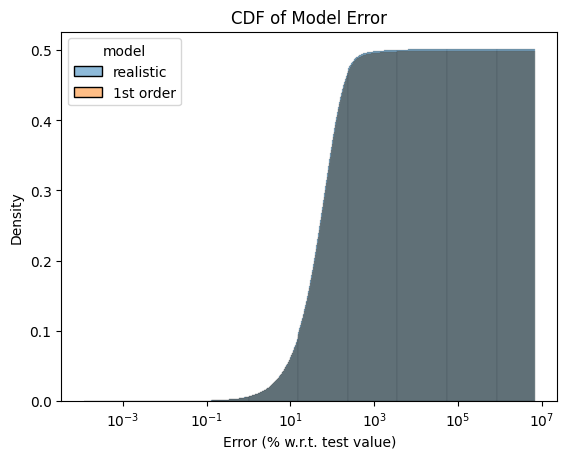

In [32]:
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.histplot(data=results, x="%_error", hue="model", stat="density", log_scale=True, cumulative=True)
ax.set_title("CDF of Model Error")
ax.set_xlabel("Error (% w.r.t. test value)")
plt.show()